In [1]:
%config Completer.use_jedi = False


In [4]:
import yaml 
import pandas as pd
from fastai.vision.all import *
import cv2
import numpy as np



In [ ]:
# Pattern:[f(x) if condition else g(x) for x in sequence]

 CREATE A FEW BUTTONS TO UPLOAD VID/ANNO FILE and SET TRAINIG DATA DIRECTORY

In [ ]:
from ipywidgets import Button
from tkinter import Tk, filedialog
from IPython.display import clear_output, display

def select_folder(b):
    clear_output()
    root = Tk()
    root.withdraw() # Hide the main window.
    root.call('wm', 'attributes', '.', '-topmost', True) # Raise the root to the top of all windows.
    b.item=filedialog.askdirectory()
    # selected folder will be set button's folder attribute.
    #print(b.folder) # Print the list of files selected.

def select_file(b):
    clear_output()
    root = Tk()
    root.withdraw() # Hide the main window.
    root.call('wm', 'attributes', '.', '-topmost', True) # Raise the root to the top of all windows.
    b.item=filedialog.askopenfilename()
    
def get_button(description,on_click_fn):   
    button= Button(description=description)
    button.on_click(on_click_fn)
    return button
    

SELECT FOLDER TO PUT FRAMES (SPLICED IMGS) ,VID and ANNO

In [8]:
buttons=[get_button('Select Img Folder',select_folder),get_button('Select Vid',select_file),get_button('Select Anno File',select_file)]
for button in buttons:
    display(button)


Button(description='Select Img Folder', style=ButtonStyle())

Button(description='Select Vid', style=ButtonStyle())

Button(description='Select Anno File', style=ButtonStyle())

In [9]:
cv2_img_folder,vid_file,anno_file=[button.item for button in buttons]

CHECK THAT RIGHT FILES /FOLDER GETS UPLOADED

In [18]:
cv2_img_folder,vid_file,anno_file

('C:/Users/ANANYA/Desktop/FASTAI_WD_LATEST/cv2_imgs',
 'C:/Users/ANANYA/Desktop/FASTAI_WD_LATEST/VIRAT_S_000203_07_001341_001458.mp4',
 'C:/Users/ANANYA/Desktop/FASTAI_WD_LATEST/VIRAT_S_000203_07_001341_001458.activities.yml')

RUN CV2 IN SPECIFIED FOLDER TO SAVE FRAMES FROM VID (MIGHT TAKE A WHILE)

In [17]:
def convert_vid_to_imgs(img_folder,vid_file):
    vidcap = cv2.VideoCapture(vid_file)
    success,image = vidcap.read()
    count = 0
    while success:
        cv2.imwrite(img_folder+'/'+str(count)+'.jpg', image)     # save frame as JPEG file      
        success,image = vidcap.read()
        print('Read a new frame: ', success)
        count += 1

convert_vid_to_imgs(cv2_img_folder,vid_file)



Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

CHECK THE NEW IMG FRAMES GOTTEN FROM THE VID. #NUM OF FILES== NUM OF FRAMES IN THE VID

In [19]:
get_image_files(cv2_img_folder)

(#3501) [Path('C:/Users/ANANYA/Desktop/FASTAI_WD_LATEST/cv2_imgs/0.jpg'),Path('C:/Users/ANANYA/Desktop/FASTAI_WD_LATEST/cv2_imgs/1.jpg'),Path('C:/Users/ANANYA/Desktop/FASTAI_WD_LATEST/cv2_imgs/10.jpg'),Path('C:/Users/ANANYA/Desktop/FASTAI_WD_LATEST/cv2_imgs/100.jpg'),Path('C:/Users/ANANYA/Desktop/FASTAI_WD_LATEST/cv2_imgs/1000.jpg'),Path('C:/Users/ANANYA/Desktop/FASTAI_WD_LATEST/cv2_imgs/1001.jpg'),Path('C:/Users/ANANYA/Desktop/FASTAI_WD_LATEST/cv2_imgs/1002.jpg'),Path('C:/Users/ANANYA/Desktop/FASTAI_WD_LATEST/cv2_imgs/1003.jpg'),Path('C:/Users/ANANYA/Desktop/FASTAI_WD_LATEST/cv2_imgs/1004.jpg'),Path('C:/Users/ANANYA/Desktop/FASTAI_WD_LATEST/cv2_imgs/1005.jpg')...]

FUNCTION TO PARSE THE ANNO FILE AND GET START/END TOKENS FOR VARIOUS ACTIVITIES ~ WORKS BUT NEED TO RETHINK ANNOTATIONS

In [20]:
def get_activity_start_end(annot_file):
    with open(annot_file, 'r') as f:
        doc = yaml.load(f, Loader=yaml.FullLoader) # also, yaml.SafeLoader
    items=[]
    for line in doc:
        if 'act' in line.keys():
            start_end=line['act']['timespan'][0]['tsr0']
            activity_name=list(line['act']['act2'].keys())
            itm=tuple(activity_name+start_end)
            items=items+[itm]
    return pd.DataFrame(items,columns=('activity_name','start','end'))   

FUNCTION TO GET Y (THE MULTICLASS LABEL GIVEN X I.E FRAME FILE NAME) - THIS LOGIC SEEMS SOLID

In [21]:
def get_activity_lbl(fn,df=get_activity_start_end(anno_file)):
    f_num=int(fn.stem)
    return list(set(df['activity_name'][ (df['end']>=f_num) & (df['start']<=f_num)]))
    

FINALLY DATALOADERS ARE HERE. LABELS ARE CORRECTLY CAPTURED FOR EACH FRAME ALTHOUGH NOT VISIBLE 

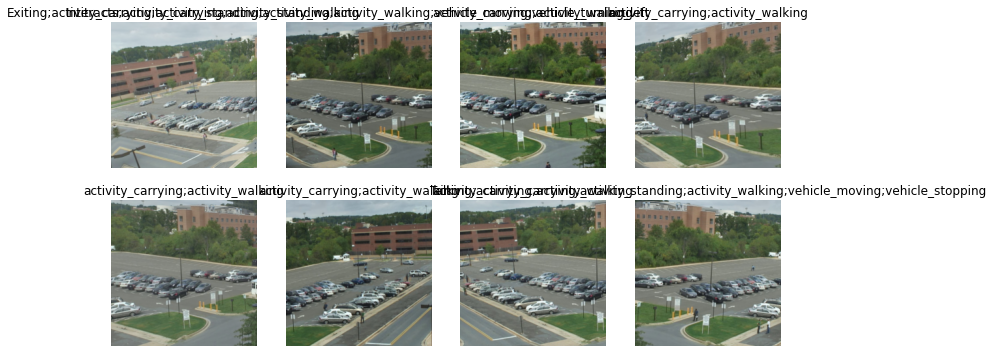

In [23]:
dblock = DataBlock(blocks=(ImageBlock(PILImage), MultiCategoryBlock()),
                   get_items=get_image_files,
                   get_y=get_activity_lbl,
                   item_tfms=Resize(460),
                   batch_tfms=aug_transforms(size=224,
                   min_scale=0.75))
dls = dblock.dataloaders(cv2_img_folder, bs=8,num_workers=0)
dls.show_batch()

DEFINE SIMPLE MODEL AND TRAIN

In [24]:
def block(ni, nf): return ConvLayer(ni, nf, stride=2)
def get_model(data_ch):
    return nn.Sequential(
    block(data_ch, 16),
    block(16, 32),
    block(32, 64),
    block(64, 128),
    block(128, 256),
    nn.AdaptiveAvgPool2d(1),
    Flatten(),
    nn.Linear(256, dls.c))

In [33]:
learn = Learner(dls,model=get_model(3),
loss_func=BCEWithLogitsLossFlat(), metrics=accuracy)

In [29]:
x,y=dls.one_batch()
x.shape,y.shape

torch.Size([8, 3, 224, 224])

SuggestedLRs(valley=tensor(0.0021))

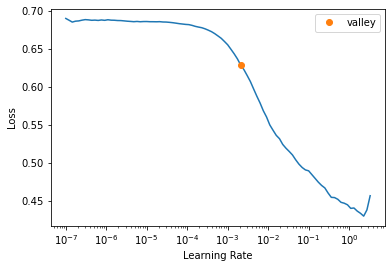

In [34]:
learn.lr_find()

WE TRIED A REASONABLE APPROACH BUT WE ARE UNLIKELY TO GET HIGH ACCURACY FOR CLASSING ACTIVITIES JUST BASED ON FRAMES/STILL IMGS,CUZ ACTIVITIES ARE
HELLA VAGUE IN THIS DS.LESS THINK MORE